In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Pix_and_power.csv')#[:-1]
 #data.plot(color='red')

In [ ]:
for i in data.select_dtypes('object').columns:
   le = LabelEncoder().fit(data[i])
   data[i] = le.transform(data[i])
data

In [ ]:
data.columns
print(data.columns)
all_data = data['power'].values.astype(float)
print(len(all_data))

#training_set = training_set.iloc[:,1:2].values
plt.figure(figsize=(100,9))
plt.plot(all_data)

#plt.plot(power, label = 'AVG power2')
plt.suptitle('power')
plt.show()


In [ ]:
data.columns
print(data.columns)
pix_data = data['pix_150'].values.astype(float)

print(len(all_data))
plt.figure(figsize=(100,9))

plt.plot(pix_data)

plt.suptitle('pix_150')
plt.show()


In [ ]:
data.columns
print(data.columns)
time_data = data['time'].values.astype(float)

print(len(all_data))
plt.figure(figsize=(32,9))


plt.plot(time_data)

plt.suptitle('time')
plt.show()

In [ ]:
num = int(len(data[[ 'pix_150']])/7)

In [ ]:
plt.figure(figsize=(12,4))
#
plt.plot( list(pix_data)[:num])

#plt.plot(pred1)
plt.title("white pixel count vs Time of day from 6:00:30 to 19:00:00 (s)")
plt.ylabel("white pixel count")
plt.xlabel("Time of day from 6:00:30 to 19:00:00 (s)")
# plt.legend(("white pixel count"))
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
#
plt.plot( all_data[:num])

#plt.plot(pred1)
plt.title("Generation vs Time of day from 6:00:30 to 19:00:00 (s)")
plt.ylabel("Generation (W)")
plt.xlabel("Time of day from 6:00:30 to 19:00:00 (s)")
# plt.legend(("white pixel count"))
plt.show()



In [ ]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[['pix_150']])
X_data1 = X_scaler.fit_transform(data[['power']])
Y_data = Y_scaler.fit_transform(data[['power']]) #np.array(data[['power']])#
X_data
Y_data

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
       end = len(dataset) - horizon
    for i in range(start, end):
       indices = range(i-window, i)
       X.append(dataset[indices])
       #print(X)
       indicey = range(i+1, i+1+horizon)
       y.append(target[indicey][-1])
    return np.array(X), np.array(y)

In [ ]:
hist_window = 80
horizon = 20
TRAIN_SPLIT = int(len(X_data)*0.7)

x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

x_train1, y_train1 = custom_ts_multi_data_prep(X_data1, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali1, y_vali1 = custom_ts_multi_data_prep(X_data1, Y_data, TRAIN_SPLIT, None, hist_window, horizon)
print(len(x_train),len(x_train1))
#len(Y_data)

In [ ]:
#print ('Multiple window of past history\n')
#print(x_train[0])
#print ('\n Target horizon\n')
#print (y_train[0])

In [ ]:
batch_size = 64
buffer_size = 10
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

train_data1 = tf.data.Dataset.from_tensor_slices((x_train1, y_train1))
train_data1 = train_data1.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data1 = tf.data.Dataset.from_tensor_slices((x_vali1, y_vali1))
val_data1 = val_data1.batch(batch_size).repeat()
val_data
x_train.shape[-2:]


In [ ]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True),input_shape=x_train.shape[-2:]),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)),
  # # #tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= False)),
  #tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dense(8, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

In [ ]:
model_path = '/content/drive/MyDrive/SkyImageModel_150.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [ ]:
history = lstm_model.fit(train_data,epochs=75,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/75
100/100 [==============================] - 68s 436ms/step - loss: 0.1091 - val_loss: 0.0568
Epoch 2/75
100/100 [==============================] - 37s 370ms/step - loss: 0.0818 - val_loss: 0.0629
Epoch 3/75
100/100 [==============================] - 37s 373ms/step - loss: 0.0858 - val_loss: 0.0503
Epoch 4/75
100/100 [==============================] - 37s 373ms/step - loss: 0.0749 - val_loss: 0.0460
Epoch 5/75
100/100 [==============================] - 37s 369ms/step - loss: 0.0696 - val_loss: 0.0502
Epoch 6/75
100/100 [==============================] - 37s 369ms/step - loss: 0.0679 - val_loss: 0.0474
Epoch 7/75
100/100 [==============================] - 37s 367ms/step - loss: 0.0681 - val_loss: 0.0493
Epoch 8/75
100/100 [==============================] - 37s 370ms/step - loss: 0.0748 - val_loss: 0.0444
Epoch 9/75
100/100 [==============================] - 36s 363ms/step - loss: 0.0676 - val_loss: 0.0460
Epoch 10/75
100/100 [==============================] - 36s 363ms/step - l

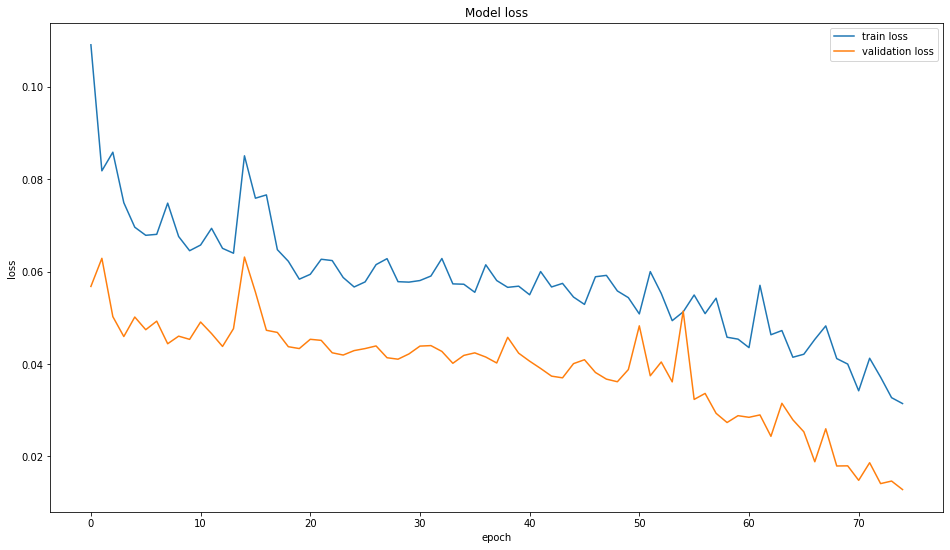

In [ ]:


plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
# num = int(len(data[[ 'pix']])/7)

In [ ]:
# data_val = X_scaler.fit_transform(data[[ 'pix']])[:num]
# Expected = X_scaler.fit_transform(data[['power' ]])[:num]
# print(len(Expected))
# print(len(data_val))

In [ ]:
# data_for_pred, Expected_val = custom_ts_multi_data_prep(data_val, Expected, 0, None, hist_window, horizon)

In [ ]:
# pred = []
# print(len(data_for_pred))

# for i in data_for_pred:
#   #print(len(i))
#   #print(i.shpae)
#   i = i.reshape(1, i.shape[0], i.shape[1])
#   pred.append(lstm_model.predict(i))
#   #break
# #pred = np.array(pred)
# pred[0][0]

In [ ]:
# act_pred =[]
# for preds in pred:
#   #print(preds)

#   pred_Inverse = Y_scaler.inverse_transform(preds)
#   act_pred.append(pred_Inverse)
# len(act_pred)
# #act_pred

In [ ]:
# predn = []
# for item in list(act_pred):
#   item = float(item[0])
#   item = round(item, 2)
#   predn.append(item)
#   #print(item)
# #pred

In [ ]:
# Expected = Y_scaler.inverse_transform(Expected)
# Expected
# Expected_list = []
# for item in list(Expected):
#   Expected_list.append(float(item[0]))
#   #print(item)
# len(Expected)

In [ ]:
# plt.figure(figsize=(12,4))
# #
# plt.plot( list(Expected[len(Expected)-len(predn):]))
# plt.plot(predn)
# # plt.plot(pred1)
# plt.title("Generation vs Time of day from 6:00:30 to 19:00:00 (s)")
# plt.ylabel("Generation (W)")
# plt.xlabel("Time of day from 6:00:30 to 19:00:00 (s)")
# plt.legend(('Measured generation','Predicted generation'))
# plt.show()

In [ ]:
lstm_model1 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True),input_shape=x_train.shape[-2:]),
  #tf.keras.layers.Dropout(0.2),
  #  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences= True)),
  # #tf.keras.layers.Dropout(0.2),
  # # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences= True)),
  # # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= False)),
  #tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dense(8, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
 ])
lstm_model1.compile(optimizer='adam', loss='mse')
lstm_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 80, 64)           8704      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 80, 32)           10368     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                      

In [ ]:
model_path = '/content/drive/MyDrive/StatisticsModel_150.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [ ]:
history = lstm_model1.fit(train_data1,epochs=50,steps_per_epoch=100,validation_data=val_data1,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - 34s 218ms/step - loss: 0.1027 - val_loss: 0.0568
Epoch 2/50
100/100 [==============================] - 19s 190ms/step - loss: 0.0743 - val_loss: 0.0480
Epoch 3/50
100/100 [==============================] - 19s 189ms/step - loss: 0.0736 - val_loss: 0.0453
Epoch 4/50
100/100 [==============================] - 18s 183ms/step - loss: 0.0641 - val_loss: 0.0459
Epoch 5/50
100/100 [==============================] - 19s 188ms/step - loss: 0.0626 - val_loss: 0.0434
Epoch 6/50
100/100 [==============================] - 18s 184ms/step - loss: 0.0606 - val_loss: 0.0441
Epoch 7/50
100/100 [==============================] - 18s 184ms/step - loss: 0.0619 - val_loss: 0.0442
Epoch 8/50
100/100 [==============================] - 18s 182ms/step - loss: 0.0676 - val_loss: 0.0450
Epoch 9/50
100/100 [==============================] - 18s 184ms/step - loss: 0.0600 - val_loss: 0.0479
Epoch 10/50
100/100 [==============================] - 18s 183ms/step - l

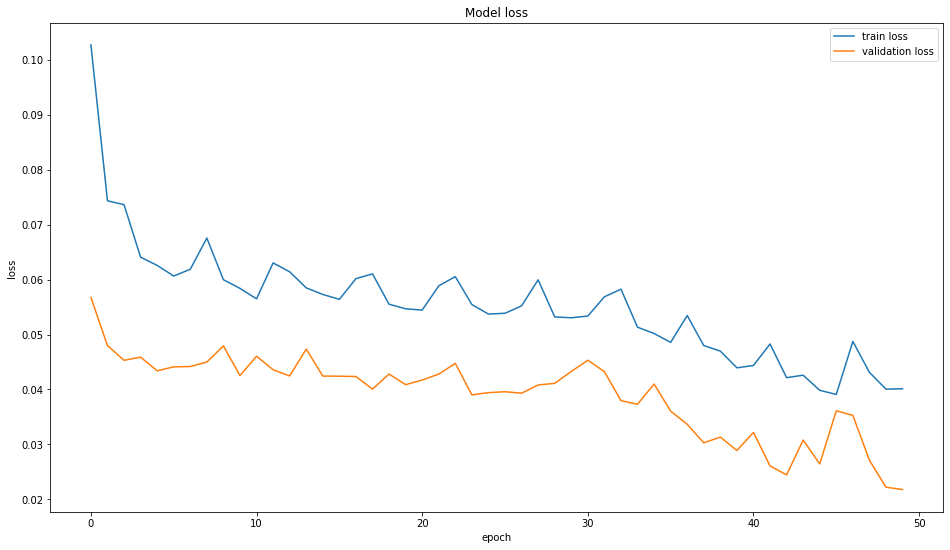

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#num = int(len(data[[ 'pix']])*0.1)

In [ ]:
data_val = X_scaler.fit_transform(data[[ 'pix_150']])[:num]
Expected = X_scaler.fit_transform(data[['power' ]])[:num]
print(len(Expected))
print(len(data_val))

1560
1560


In [ ]:
data_val1 = X_scaler.fit_transform(data[[ 'power']])[:num]
Expected1 = X_scaler.fit_transform(data[['power' ]])[:num]
print(len(Expected1))
print(len(data_val1))

1560
1560


In [ ]:
data_for_pred, Expected_val = custom_ts_multi_data_prep(data_val, Expected, 0, None, hist_window, horizon)
data_for_pred1, Expected_val1 = custom_ts_multi_data_prep(data_val1, Expected1, 0, None, hist_window, horizon)
#data_for_pred[0], Expected_val[0]

In [ ]:
# len(data_for_pred)

In [ ]:
pred = []
print(len(data_for_pred))

for i in data_for_pred:
  #print(len(i))
  #print(i.shpae)
  i = i.reshape(1, i.shape[0], i.shape[1])
  pred.append(lstm_model.predict(i))
  #break
#pred = np.array(pred)
pred[0][0]

1460


array([0.0563373], dtype=float32)

In [ ]:
pred1 = []
print(len(data_for_pred1))

for i in data_for_pred1:
  #print(len(i))
  #print(i.shpae)
  i = i.reshape(1, i.shape[0], i.shape[1])
  pred1.append(lstm_model1.predict(i))
  #break
#pred = np.array(pred)
pred1[0][0]

1460


array([0.0298578], dtype=float32)

In [ ]:
#pred

In [ ]:
act_pred =[]
for preds in pred:
  #print(preds)

  pred_Inverse = Y_scaler.inverse_transform(preds)
  act_pred.append(pred_Inverse)
len(act_pred)
#act_pred

1460

In [ ]:
act_pred1 =[]
for preds in pred1:
  #print(preds)

  pred_Inverse = Y_scaler.inverse_transform(preds)
  act_pred1.append(pred_Inverse)
len(act_pred1)

1460

In [ ]:
predn = []
for item in list(act_pred):
  item = float(item[0])
  item = round(item, 2)
  predn.append(item)
  #print(item)
#pred

In [ ]:
predn1 = []
for item in list(act_pred1):
  item = float(item[0])
  item = round(item, 2)
  predn1.append(item)
  #print(item)
#pred

In [ ]:
len(Expected), len(pred)

(1560, 1460)

In [ ]:
Expected = Y_scaler.inverse_transform(Expected)
Expected
Expected_list = []
for item in list(Expected):
  Expected_list.append(float(item[0]))
  #print(item)
len(Expected)

1560

In [ ]:
Expected1 = Expected[len(Expected)-len(predn):]

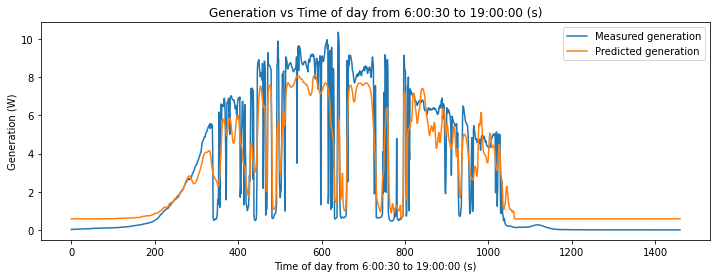

In [ ]:
plt.figure(figsize=(12,4))
#
plt.plot( list(Expected1))
plt.plot(predn)
# plt.plot(pred1)
plt.title("Generation vs Time of day from 6:00:30 to 19:00:00 (s)")
plt.ylabel("Generation (W)")
plt.xlabel("Time of day from 6:00:30 to 19:00:00 (s)")
plt.legend(('Measured generation','Predicted generation'))
plt.show()

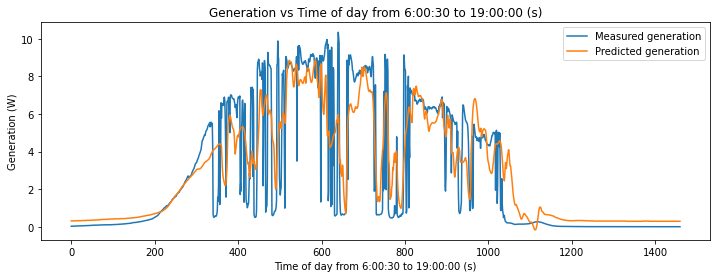

In [ ]:
plt.figure(figsize=(12,4))
#
plt.plot( list(Expected1))
plt.plot(predn1)
#plt.plot(pred1)
plt.title("Generation vs Time of day from 6:00:30 to 19:00:00 (s)")
plt.ylabel("Generation (W)")
plt.xlabel("Time of day from 6:00:30 to 19:00:00 (s)")
plt.legend(('Measured generation','Predicted generation'))
plt.show()

In [ ]:
rmse = []
for i in range(len(Expected1)):
  per_err = (Expected1[i][0] - predn[i])**2
  # print(per_err)
  rmse.append(per_err)
rmse = list(rmse)
rmse = (sum(rmse)/len(rmse))**0.5
print('rmse value sky imagery model',rmse)

rmse value sky imagery model 1.2113069046417968


In [ ]:
rmse = []
for i in range(len(predn1)):
  per_err = (Expected1[i][0] - predn1[i])**2
  rmse.append(per_err)
rmse = list(rmse)
rmse = (sum(rmse)/len(rmse))**0.5
print('rmse value statistical model',rmse)

rmse value statistical model 1.5910719160020423


In [ ]:
mape = []
count = 0
for i in range(len(pred1)):
  if (Expected[i][0] > pred1[i]):
    count+=1
  per_err = (Expected[i][0] - pred1[i]) / pred1[i]
  per_err = abs(per_err)
  #print(Expected[i][0],pred[i],Expected[i][0]-pred[i], per_err)
  mape.append(per_err)
mape = list(mape)
mape = sum(mape)/len(mape)
mape

array([[17.12091]], dtype=float32)

In [ ]:
def rmse1(pred, expected):
  rmse = []

  for i in range(len(pred)):
    per_err = (Expected1[i][0] - pred[i])**2
    rmse.append(per_err)
  rmse = list(rmse)
  rmse = (sum(rmse)/len(rmse))**0.5
  return rmse

In [ ]:
predn1[0]*0.9

0.279

In [ ]:
ensemble = []
for i in range(len(pred)):
  ensemble.append((predn[i]*0.9+predn1[i]*0.1))
print(ensemble)
rmse1(ensemble,Expected1)


[0.553, 0.553, 0.553, 0.553, 0.553, 0.553, 0.553, 0.553, 0.553, 0.553, 0.553, 0.553, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.555, 0.555, 0.555, 0.555, 0.555, 0.555, 0.555, 0.555, 0.555, 0.555, 0.556, 0.556, 0.556, 0.556, 0.556, 0.556, 0.556, 0.556, 0.556, 0.556, 0.556, 0.557, 0.557, 0.557, 0.557, 0.557, 0.557, 0.557, 0.557, 0.557, 0.557, 0.558, 0.558, 0.558, 0.558, 0.558, 0.558, 0.558, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.56, 0.56, 0.56, 0.56, 0.56, 0.561, 0.561, 0.561, 0.561, 0.5700000000000001, 0.5700000000000001, 0.5700000000000001, 0.5700000000000001, 0.561, 0.561, 0.561, 0.562, 0.562, 0.5710000000000001, 0.5710000000000001, 0.5710000000000001, 0.5710000000000001, 0.5710000000000001, 0.5720000000000001, 0.5720000000000001, 0.5720000000000001, 0.5720000000000001, 0.5720000000000001, 0.5720000000000001, 0.5720000000000001, 0.5720000000000001, 0.5720000000000001, 0.5730000000000001, 0.5730000000000001, 0.57300000000000

1.2185169953340047

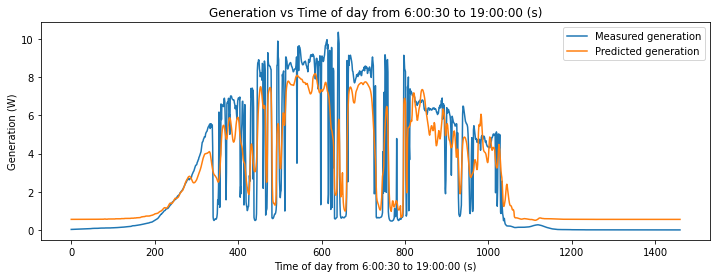

In [ ]:
plt.figure(figsize=(12,4))
#
plt.plot( list(Expected1))
plt.plot(ensemble)
#plt.plot(pred1)
plt.title("Generation vs Time of day from 6:00:30 to 19:00:00 (s)")
plt.ylabel("Generation (W)")
plt.xlabel("Time of day from 6:00:30 to 19:00:00 (s)")
plt.legend(('Measured generation','Predicted generation'))
plt.show()

In [ ]:
weights_list = list(range(0,100,1))
print(weights_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [ ]:

ensemble = []
RMSE = []
for weight in weights_list:
  weight = weight/100
  ensemble_new=[]
  for i in range(len(pred)):
    ensemble_new.append((predn[i]*(1-weight)+predn1[i]*weight))


  RMSE.append(rmse1(ensemble_new,Expected1))
  ensemble.append(ensemble_new)

In [ ]:
ensemble[0]


[0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.59,
 0.59,
 0.59,
 0.59,
 0.58,
 0.58,
 0.58,
 0.58,
 0.58,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.61,
 0.61,
 0.61,
 0.61,
 0.61,
 0.61,
 0.61,
 0.61,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.63,
 0.63,

In [ ]:
count = 0
for ensemble1 in ensemble:
  plt.figure(figsize=(40,12))
  #
  plt.plot( list(Expected1))
  plt.plot(ensemble1)
  plt.plot(predn)
  plt.plot(predn1)
  plt.title("Generation vs Time of day from 6:00:30 to 19:00:00 (s)")
  plt.ylabel("Generation (W)")
  plt.xlabel("Time of day from 6:00:30 to 19:00:00 (s)")
  plt.legend(('Measured generation','Predicted generation - ensemble model', 'Predicted generation - sky imagery model', 'Predicted generation - satistical model'))
  plt.show()
  print(RMSE[count], weights_list[count]/100)
  count +=1

In [ ]:
weights_list = list(range(0,100,1))

100 100


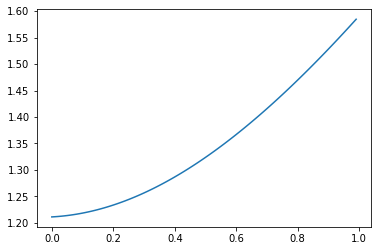

In [ ]:

weights_list = list(map(lambda x: x/100,weights_list))
print(len(weights_list),len(RMSE))
plt.plot( weights_list,RMSE)
# plt.plot()

In [ ]:
weights_list

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98,
 0.99]

In [ ]:
RMSE